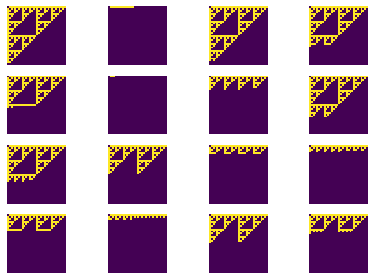

In [4]:
import time
from cffi import FFI
from array2gif import write_gif
import numpy as np
import random
import matplotlib.pyplot as plt

binary      = 'sierp0.bin'

with open(binary, "rb") as f:
    prog = f.read()
    
# init nv6502
def init(ffi):
    _nv6502 = ffi.dlopen("./nv6502.so");
    return _nv6502


def execute(prog):
    
    ffi = FFI()
    ffi.cdef("""
       typedef uint8_t u8;
       void run(int num_blocks, int threads_per_block, int steps, int iters, const char *name);
       extern u8 mem[256][0x1000];
    """)

    blocks = 1
    threads_per_block = 16
    total_threads = blocks * threads_per_block
    cycles = 5000
    
    plot_w = int(np.sqrt(total_threads))
    
    C = init(ffi)
    C.run(blocks, threads_per_block, cycles, 1, b'sierp0.bin')
    _scr = np.zeros((total_threads, 1024), dtype='uint8')
    
    for t in range(total_threads):
        for i in range(0x200, 0x600): _scr[t][i-0x200] = C.mem[t][i]
    _scr = _scr.reshape(total_threads,32,32)
    
    fig, axs = plt.subplots(plot_w, plot_w, sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0)
    
    for t in range(total_threads):
        i = t//plot_w
        j = t %plot_w
        axs[i, j].axis("off")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].matshow(_scr[t])
        
    fig.tight_layout()
    
execute('')


In [1]:
# we just an 6502 emulator running on a GPU
# each GPU thread was configured to run a different
# number of iterations